# Black Friday Dataset Matrix Evaluation

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import glob

## Loading Dataset

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [3]:
%%bigquery train_df
SELECT * FROM `aa-ai-specialisation.black_friday.preprocessed_train_df`

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
%%bigquery test_df
SELECT * FROM `aa-ai-specialisation.black_friday.preprocessed_test_df`

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

X= train_df_copy.drop(columns=['User_ID', 'Product_ID','Purchase'])
y = train_df_copy['Purchase'].astype(int)
# Split the data with the same random_state when training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Model Evaluation

Evaluate the Linear Regression:
RMSE for Linear Regression: 4616.707666158212


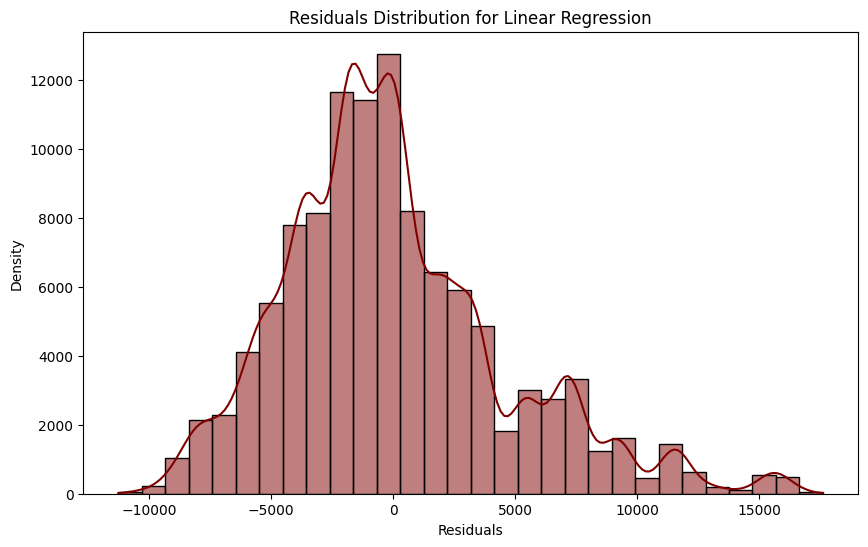

Evaluate the Random Forest:
RMSE for Random Forest: 2920.5985431351137


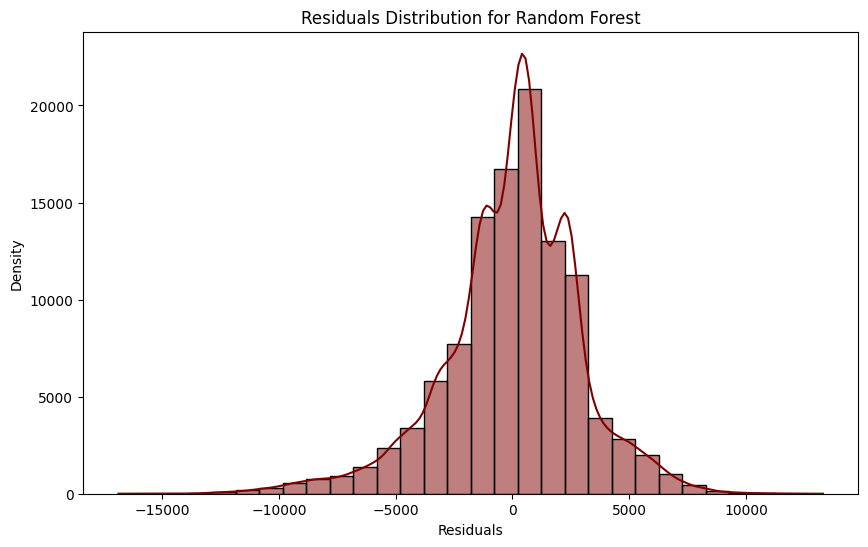

Evaluate the XGBoost:
RMSE for XGBoost: 2870.9729278111936


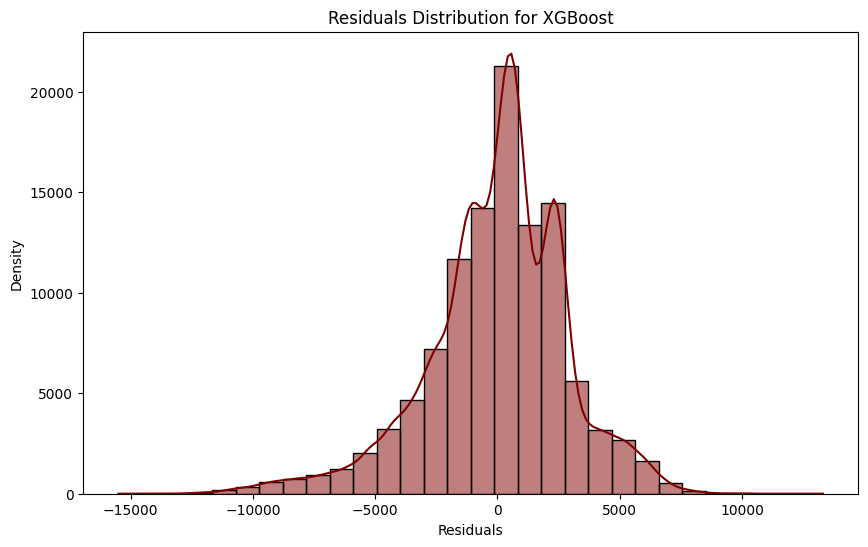

In [25]:

# Model file names
model_filenames = ['./model_checkpoints/linear_regression_model.joblib', 
                   './model_checkpoints/random_forest_model.joblib',
                   './model_checkpoints/model.joblib']
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']

# Evaluate each model
for model_filename, model_name in zip(model_filenames, model_names):
    print(f'Evaluate the {model_name}:')
    # Load the model
    model = joblib.load(model_filename)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate RMSE
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {model_name}: {rmse}')

    # Calculate residuals
    residuals = y_test - y_pred
    
    # Plot the residual distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, color='maroon', bins=30)
    plt.title(f'Residuals Distribution for {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.show()



In [16]:
from google.cloud import aiplatform

from google.cloud.aiplatform import hyperparameter_tuning as hpt


def create_hyperparameter_tuning_job_sample(
    project: str,
    location: str,
    staging_bucket: str,
    display_name: str,
    container_uri: str,
):
    aiplatform.init(project=project, location=location, staging_bucket=staging_bucket)

    worker_pool_specs = [
        {
            "machine_spec": {
                "machine_type": "n1-standard-4",
                "accelerator_type": "NVIDIA_TESLA_K80",
                "accelerator_count": 1,
            },
            "replica_count": 1,
            "container_spec": {
                "image_uri": container_uri,
                "command": [],
                "args": [],
            },
        }
    ]

    custom_job = aiplatform.CustomJob(
        display_name='custom_xgboost',
        worker_pool_specs=worker_pool_specs,
    )

    hpt_job = aiplatform.HyperparameterTuningJob(
        display_name=display_name,
        custom_job=custom_job,
        metric_spec={
            'val_rmse': 'minimize',
        },
        
        parameter_spec={
            "boost-rounds": hpt.IntegerParameterSpec(min=10, max=100, scale="linear"),
            "learning_rate": hpt.DoubleParameterSpec(min=0.001, max=0.1, scale="log"),
            "n_estimators": hpt.DoubleParameterSpec(min=100, max=300, scale="linear"),
            "subsample":hpt.DoubleParameterSpec(min=0.8, max=1, scale="none"),
            "colsample_bytree":hpt.DoubleParameterSpec(min=0.8, max=1, scale="none"),
        },
        search_algorithm=None,
        max_trial_count=5,
        parallel_trial_count=1,
    )
    

    hpt_job.run()

    print(hpt_job.resource_name)
    return hpt_job


In [17]:
project = "aa-ai-specialisation"
location = "us-central1"
staging_bucket='gs://specialization_black_friday'
display_name = 'xgboost_evaluation_v1'
container_uri='us-central1-docker.pkg.dev/aa-ai-specialisation/bf-repo/bfd'
create_hyperparameter_tuning_job_sample(
    project,
    location,
    staging_bucket,
    display_name,
    container_uri
)

Creating HyperparameterTuningJob
HyperparameterTuningJob created. Resource name: projects/653183562498/locations/us-central1/hyperparameterTuningJobs/4096332480263487488
To use this HyperparameterTuningJob in another session:
hpt_job = aiplatform.HyperparameterTuningJob.get('projects/653183562498/locations/us-central1/hyperparameterTuningJobs/4096332480263487488')
View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4096332480263487488?project=653183562498
HyperparameterTuningJob projects/653183562498/locations/us-central1/hyperparameterTuningJobs/4096332480263487488 current state:
JobState.JOB_STATE_PENDING
HyperparameterTuningJob projects/653183562498/locations/us-central1/hyperparameterTuningJobs/4096332480263487488 current state:
JobState.JOB_STATE_RUNNING
HyperparameterTuningJob projects/653183562498/locations/us-central1/hyperparameterTuningJobs/4096332480263487488 current state:
JobState.JOB_STATE_RUNNING
HyperparameterTuningJ

resource name: projects/653183562498/locations/us-central1/hyperparameterTuningJobs/4096332480263487488